In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import json
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf

from keras.applications import EfficientNetB0
from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, GlobalAveragePooling2D, Dropout, Dense

#from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.utils import to_categorical

from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split

# Damage Dataset

In [3]:
def get_image_path(directory, image_name):
    return os.path.join(directory, image_name)

In [4]:
with open(r'data/Log_Ends_Train.json', 'r') as f:
    PITH_JSON_TRAIN = json.load(f)
    
with open(r'data/Log_Ends_Val.json', 'r') as f:
    PITH_JSON_VAL = json.load(f)

In [5]:
def get_bbox(image_name, json_file):
    for image_item in json_file["images"]:
        if image_item["image_name"] == image_name:
            return image_item["labels"][0]["bbox"]
    return None

def get_xy_coordinates(image, image_name, json_file):
    x,y,w,h = get_bbox(image_name, json_file)
    w = np.abs(w-x)
    h = np.abs(h-y)
    height, width = image.shape[0], image.shape[1]
    return (x + w/2)/width, (y + h/2)/height

In [6]:
#STOP

In [7]:
labels_Log_Ends_Train = []
images_Log_Ends_Train = []
for image_item in PITH_JSON_TRAIN["images"]:
    image_name = image_item["image_name"]
    image_path = get_image_path(r'data/Log_Ends_Train', image_name)
    image = plt.imread(image_path)
    labels_Log_Ends_Train.append(get_xy_coordinates(image, image_name, PITH_JSON_TRAIN)) 
    images_Log_Ends_Train.append(image)

labels_Log_Ends_Val = []
images_Log_Ends_Val = []
for image_item in PITH_JSON_VAL["images"]: 
    image_name = image_item["image_name"]
    image_path = get_image_path(r'data/Log_Ends_Val', image_name)
    image = plt.imread(image_path)
    labels_Log_Ends_Val.append(get_xy_coordinates(image, image_name, PITH_JSON_VAL))
    images_Log_Ends_Val.append(image)

In [8]:
prediction = labels_Log_Ends_Train[0]
img = images_Log_Ends_Train[0]
height, width = img.shape[0], img.shape[1]
plt.imshow(img)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.show()

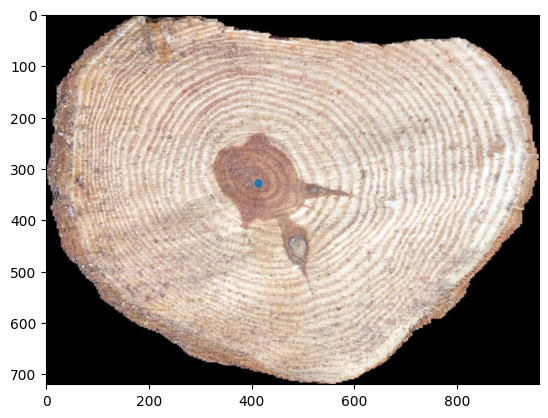

In [9]:
prediction =labels_Log_Ends_Val[0]
img = images_Log_Ends_Val[0]
height, width = img.shape[0], img.shape[1]
plt.imshow(img)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.show()

In [10]:
#STOP

# Config

In [11]:
training_percent = 0.9

epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

METRICS = [ 
    tf.keras.metrics.MAE,
    tf.keras.metrics.MSE,
    tf.keras.metrics.RootMeanSquaredError()
]


#'accuracy', tf.keras.metrics.AUC()
#tf.keras.metrics.Precision()
#tf.keras.metrics.Recall()
#tfa.metrics.F1Score(num_classes=n_outputs, average='macro')

IMG_SIZE = 224 # Image resolution

In [12]:
#STOP

# Model

In [13]:
class Baseline():
    def __init__(self, metrics=METRICS):
        # Define the input shape
        input_shape = (224, 224, 3)
        
        '''
        # Instantiate the base model (EfficientNetB0)
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

        # Freeze the weights of the base model
        #base_model.trainable = False

        # Create a new model on top of the base model
        model = Sequential([
            InputLayer(input_shape=input_shape),
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])
        '''

        
        inputs = Input(shape=input_shape)
        x = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        prediction = Dense(2, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=prediction)
        
        # Compile the model
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=metrics)

        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

# Prepare dataset

In [14]:
resized_images_Log_Ends_Train = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in images_Log_Ends_Train]
resized_images_Log_Ends_Val = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in images_Log_Ends_Val]

X_train = np.array(resized_images_Log_Ends_Train)
y_train = np.array(labels_Log_Ends_Train)

X_holdout = np.array(resized_images_Log_Ends_Val)
y_holdout = np.array(labels_Log_Ends_Val)

# split the data into a holdout set and the rest for K-Fold cross-validation
#X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=training_percent, random_state=42)

In [15]:
# create the model and iterate over each fold

model = Baseline()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
______________________________________________

Epoch 1/50
2/2 - 30s - loss: 0.0469 - mean_absolute_error: 0.1732 - mean_squared_error: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 0.0284 - val_mean_absolute_error: 0.1471 - val_mean_squared_error: 0.0284 - val_root_mean_squared_error: 0.1685 - 30s/epoch - 15s/step
Epoch 2/50
2/2 - 6s - loss: 0.0259 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0259 - root_mean_squared_error: 0.1610 - val_loss: 0.0254 - val_mean_absolute_error: 0.1368 - val_mean_squared_error: 0.0254 - val_root_mean_squared_error: 0.1593 - 6s/epoch - 3s/step
Epoch 3/50
2/2 - 6s - loss: 0.0305 - mean_absolute_error: 0.1458 - mean_squared_error: 0.0305 - root_mean_squared_error: 0.1747 - val_loss: 0.0222 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0222 - val_root_mean_squared_error: 0.1491 - 6s/epoch - 3s/step
Epoch 4/50
2/2 - 7s - loss: 0.0233 - mean_absolute_error: 0.1288 - mean_squared_error: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.0208 - val_mean_absolute_error: 0.11

Epoch 31/50
2/2 - 6s - loss: 0.0148 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0156 - val_mean_absolute_error: 0.1005 - val_mean_squared_error: 0.0156 - val_root_mean_squared_error: 0.1249 - 6s/epoch - 3s/step
Epoch 32/50
2/2 - 7s - loss: 0.0173 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0162 - val_mean_absolute_error: 0.1027 - val_mean_squared_error: 0.0162 - val_root_mean_squared_error: 0.1272 - 7s/epoch - 4s/step
Epoch 33/50
2/2 - 6s - loss: 0.0153 - mean_absolute_error: 0.1009 - mean_squared_error: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0165 - val_mean_absolute_error: 0.1036 - val_mean_squared_error: 0.0165 - val_root_mean_squared_error: 0.1284 - 6s/epoch - 3s/step
Epoch 34/50
2/2 - 7s - loss: 0.0175 - mean_absolute_error: 0.1078 - mean_squared_error: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0162 - val_mean_absolute_error: 0.1

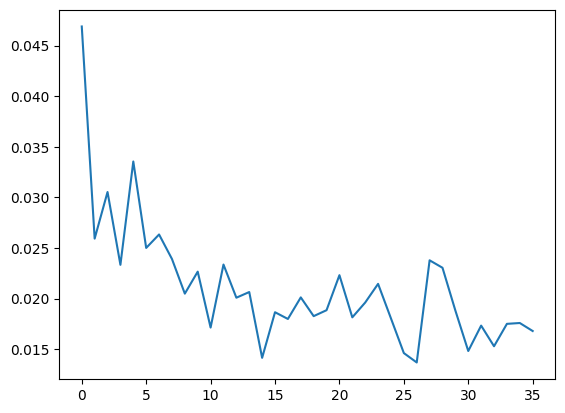

Loss on validation set: 0.01334893237799406
MAE on validation set: 0.09362979978322983
MSE on validation set: 0.01334893237799406
RMSE on validation set: 0.11553757637739182
Epoch 1/50
2/2 - 7s - loss: 0.0155 - mean_absolute_error: 0.0953 - mean_squared_error: 0.0155 - root_mean_squared_error: 0.1243 - val_loss: 0.0104 - val_mean_absolute_error: 0.0844 - val_mean_squared_error: 0.0104 - val_root_mean_squared_error: 0.1022 - 7s/epoch - 3s/step
Epoch 2/50
2/2 - 7s - loss: 0.0163 - mean_absolute_error: 0.1052 - mean_squared_error: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0107 - val_mean_absolute_error: 0.0862 - val_mean_squared_error: 0.0107 - val_root_mean_squared_error: 0.1032 - 7s/epoch - 3s/step
Epoch 3/50
2/2 - 7s - loss: 0.0148 - mean_absolute_error: 0.0907 - mean_squared_error: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0110 - val_mean_absolute_error: 0.0885 - val_mean_squared_error: 0.0110 - val_root_mean_squared_error: 0.1050 - 7s/epoch - 3s/step
Epoch 4

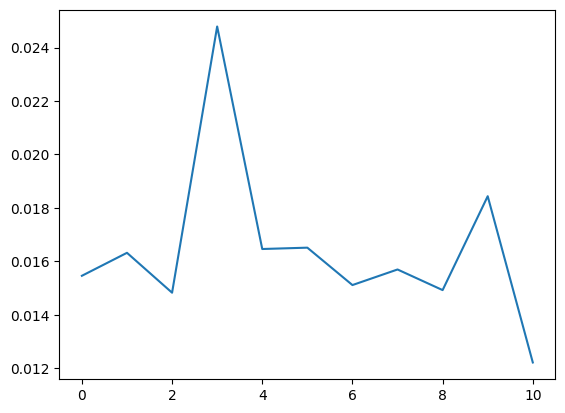

Loss on validation set: 0.010447962209582329
MAE on validation set: 0.08435879647731781
MSE on validation set: 0.010447962209582329
RMSE on validation set: 0.10221526771783829
Epoch 1/50
2/2 - 7s - loss: 0.0185 - mean_absolute_error: 0.1106 - mean_squared_error: 0.0185 - root_mean_squared_error: 0.1360 - val_loss: 0.0149 - val_mean_absolute_error: 0.0947 - val_mean_squared_error: 0.0149 - val_root_mean_squared_error: 0.1220 - 7s/epoch - 3s/step
Epoch 2/50
2/2 - 7s - loss: 0.0226 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.0148 - val_mean_absolute_error: 0.0958 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1218 - 7s/epoch - 4s/step
Epoch 3/50
2/2 - 7s - loss: 0.0193 - mean_absolute_error: 0.1069 - mean_squared_error: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0148 - val_mean_absolute_error: 0.0971 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1217 - 7s/epoch - 3s/step
Epoch

Epoch 31/50
2/2 - 6s - loss: 0.0139 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0079 - val_mean_absolute_error: 0.0768 - val_mean_squared_error: 0.0079 - val_root_mean_squared_error: 0.0889 - 6s/epoch - 3s/step
Epoch 32/50
2/2 - 6s - loss: 0.0170 - mean_absolute_error: 0.1031 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0077 - val_mean_absolute_error: 0.0751 - val_mean_squared_error: 0.0077 - val_root_mean_squared_error: 0.0877 - 6s/epoch - 3s/step
Epoch 33/50
2/2 - 6s - loss: 0.0161 - mean_absolute_error: 0.1017 - mean_squared_error: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0076 - val_mean_absolute_error: 0.0747 - val_mean_squared_error: 0.0076 - val_root_mean_squared_error: 0.0872 - 6s/epoch - 3s/step
Epoch 34/50
2/2 - 6s - loss: 0.0140 - mean_absolute_error: 0.0938 - mean_squared_error: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.0078 - val_mean_absolute_error: 0.0

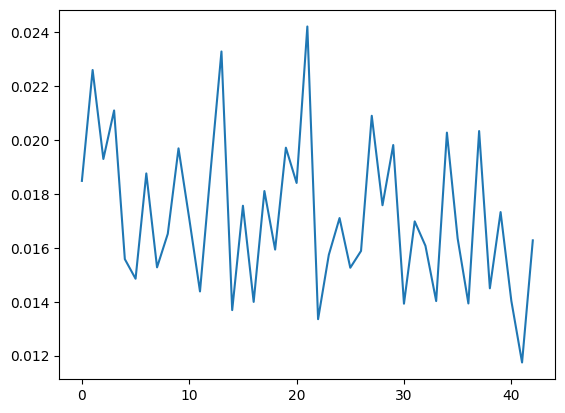

Loss on validation set: 0.007609815802425146
MAE on validation set: 0.074653260409832
MSE on validation set: 0.007609815802425146
RMSE on validation set: 0.0872342586517334
K-fold cross-validation Loss: 0.010468903463333845
K-fold cross-validation MAE: 0.08421395222345988
K-fold cross-validation MSE: 0.010468903463333845
K-fold cross-validation RMSE: 0.10166236758232117
Loss on holdout set: 0.00891053956001997
MAE on holdout set: 0.07532749325037003
MSE on holdout set: 0.00891053956001997
RMSE on holdout set: 0.09439564496278763


In [16]:
results_loss = []
results_mae = []
results_mse = []
results_rmse = []

for train_index, val_index in kf.split(X_train):
    # split the dataset into training and validation sets for this fold
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    history = model.train(X_train_kf, y_train_kf, X_val_kf, y_val_kf, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    
    loss, mae, mse, rmse = model.evaluate(X_val_kf, y_val_kf)
    print('Loss on validation set:', loss)
    print('MAE on validation set:', mae)
    print('MSE on validation set:', mse)
    print('RMSE on validation set:', rmse)

    results_loss.append(loss)
    results_mae.append(mae)
    results_mse.append(mse)
    results_rmse.append(rmse)
    
# Calculate the average for the K-fold cross-validation
print(f"K-fold cross-validation Loss: {sum(results_loss) / len(results_loss)}")
print(f"K-fold cross-validation MAE: {sum(results_mae) / len(results_mae)}")
print(f"K-fold cross-validation MSE: {sum(results_mse) / len(results_mse)}")
print(f"K-fold cross-validation RMSE: {sum(results_rmse) / len(results_rmse)}")

loss, mae, mse, rmse = model.evaluate(X_holdout, y_holdout)
print('Loss on holdout set:', loss)
print('MAE on holdout set:', mae)
print('MSE on holdout set:', mse)
print('RMSE on holdout set:', rmse)

In [17]:
#STOP

1/1 [==============================] - 0s 63ms/step


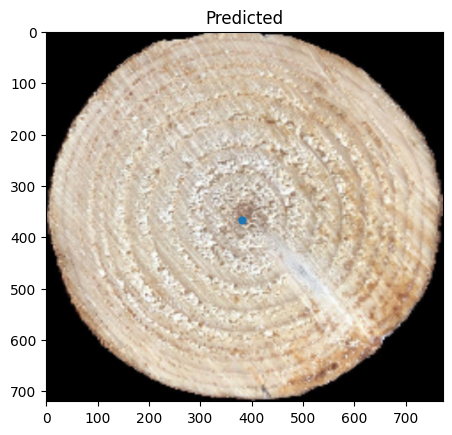

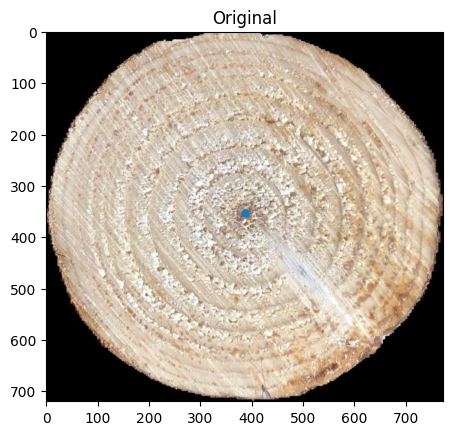

In [33]:
img_ind = 1

image = images_Log_Ends_Train[img_ind]
height, width = image.shape[0], image.shape[1]
image = cv2.resize(image, (224,224))
image = np.expand_dims(image, axis=0)
prediction = model.predict(image)[0]
image = np.squeeze(image, axis = 0)
image = cv2.resize(image, (width, height))
plt.imshow(image)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.title("Predicted")
plt.show()

prediction = labels_Log_Ends_Train[img_ind]
img = images_Log_Ends_Train[img_ind]
height, width = img.shape[0], img.shape[1]
plt.imshow(img)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.title("Original")
plt.show()

1/1 [==============================] - 0s 66ms/step


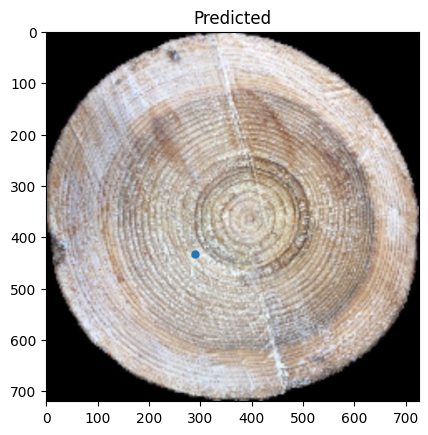

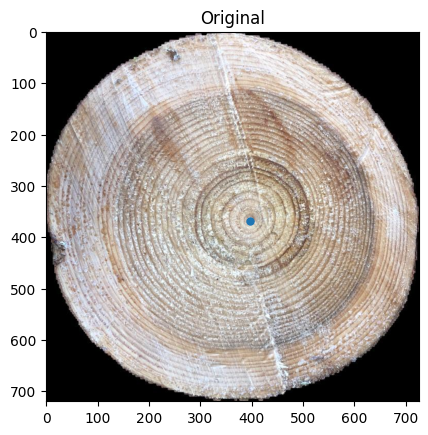

In [34]:
img_ind = 1


image = images_Log_Ends_Val[1]
height, width = image.shape[0], image.shape[1]
image = cv2.resize(image, (224,224))
image = np.expand_dims(image, axis=0)
prediction = model.predict(image)[0]
image = np.squeeze(image, axis = 0)
image = cv2.resize(image, (width, height))
plt.imshow(image)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.title("Predicted")
plt.show()

prediction = labels_Log_Ends_Val[img_ind]
img = images_Log_Ends_Val[img_ind]
height, width = img.shape[0], img.shape[1]
plt.imshow(img)
plt.plot(prediction[0]*width, prediction[1]*height, '.', markersize = 10)
plt.title("Original")
plt.show()

In [ ]:
#STOP